In [193]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install gym[toy_text]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [194]:
# Setup Environment
import gym
from colabgymrender.recorder import Recorder
from typing import List, Set, Dict, Tuple, Optional
import numpy as np
from tqdm import tqdm
import os 
import numpy.ma as ma
from numpy.core.getlimits import inf
from collections import defaultdict
from gym.spaces import Space, Discrete
import random 
import matplotlib.pyplot as plt

os.environ["SDL_VIDEODRIVER"] = "dummy"

In [195]:
class Agent(object):
  def __init__(self, state_space: Space, action_space: Space, discount_rate: float):
    self._state_spacee = state_space
    self._action_space = action_space
    self._discount_rate = discount_rate
    self._prev_action = None
    self._prev_state = None

In [196]:
class OnPolicyMonteCarloAgent(Agent):
  def __init__(self, state_space: Discrete, action_space: Discrete, discount_rate: float, epsilon: float):
    super().__init__(state_space, action_space, discount_rate) 
    self._policy = np.full((state_space.n, action_space.n), 1.0 / action_space.n) 
    self._action_values = np.full((state_space.n, action_space.n), 0.0) 
    self._returns = defaultdict(lambda: defaultdict(list))
    self._epsilon = epsilon
  
  def update(self, episode: list):
    G = 0
    for i, (state, action, reward) in enumerate(episode[::-1]):
      for s,a,_ in episode[:i]:
        if s == state and a == action:
          continue
      G = self._discount_rate * G + reward 
      self._returns[state][action].append(G)
      self._action_values[state][action] = np.mean(self._returns[state][action])
      # Randomly break tie
      optimal_action = random.choice(np.where(self._action_values[state] == np.max(self._action_values[state]))[0])
      num_actions = len(self._policy[state])
      self._policy[state] = np.full(num_actions, self._epsilon / num_actions)
      self._policy[state][optimal_action] += 1 - self._epsilon
  
def test_on_policy_monte_carlo_agent():
  agent = OnPolicyMonteCarloAgent(
    state_space=Discrete(4), 
    action_space=Discrete(4), 
    discount_rate=0.9,
    epsilon=0.1
  )
#  episode = play_episode(agent, env)
  episode = [(0,1,0), (2,2,1)]
  agent.update(episode)
  assert agent._returns[0][1] == [0.9]
  assert agent._returns[2][2] == [1.0]
  assert agent._action_values[0][1] == 0.9
  assert agent._action_values[2][2] == 1.0
  episode = [(0,1,0)]
  agent.update(episode)
  assert agent._returns[0][1] == [0.9, 0.0]
  assert agent._action_values[0][1] == 0.45
  print("test_on_policy_monte_carlo_agent passed!")

test_on_policy_monte_carlo_agent() 

test_on_policy_monte_carlo_agent passed!


In [197]:
def play_episode(policy: np.array, env: gym.Env):
  prev_state = env.reset()
  terminal = False
  episode = []
  while not terminal:
    action = np.random.choice(len(policy[prev_state]), p = policy[prev_state])
    state, reward, terminal, info = env.step(action)
    episode.append((prev_state, action, reward))
    prev_state = state
  return episode


In [198]:
### On policy learning ###
# Create Environment.
#env = gym.make('Taxi-v3')
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
directory = './video'
env = Recorder(env, directory)
online_agent = OnPolicyMonteCarloAgent(

  state_space=env.observation_space, 
  action_space=env.action_space, 
  discount_rate=0.8,
  epsilon=0.1
)
max_episode = 100
rewarding = 0
for i in tqdm(range(max_episode)):
  episode = play_episode(online_agent._policy, env)
  if (episode[-1][2] > 0):
    rewarding += 1
  online_agent.update(episode)
print(f"rewarding episodes {rewarding}")

env.play()

100%|██████████| 100/100 [00:02<00:00, 34.30it/s]


rewarding episodes 76


[[0.25961864 0.19605184 0.1048576  0.        ]
 [0.33156031 0.         0.03846534 0.        ]
 [0.43068331 0.56192594 0.72649018 0.        ]
 [0.         0.71453333 0.97236376 0.        ]]


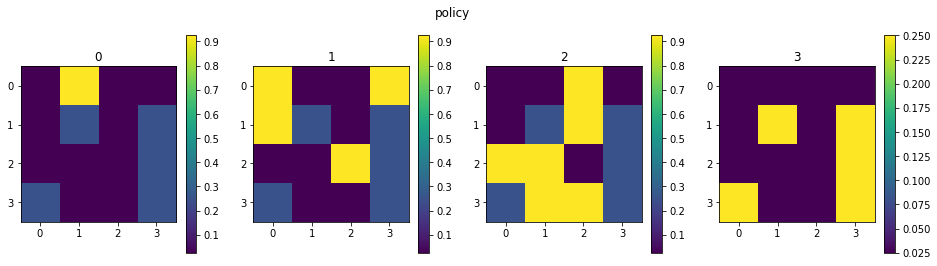

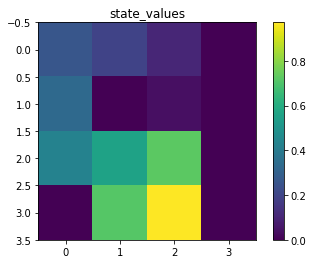

In [199]:
# Plot the action values.
# cliff walking
#shape = (4,12,4)
# frozen lake
## small
shape = (4,4,4)
## large
#shape = (8,8,4)

action_values = agent._policy.reshape(shape)
num_actions = action_values.shape[-1]
plt.figure(1, figsize=(16,4))
plt.suptitle("policy")
for i in range(num_actions):
  plt.subplot(1, num_actions,i+1)
  plt.title(i)
  plt.imshow(action_values[:,:,i])
  plt.colorbar(orientation='vertical')

plt.figure(0)
plt.imshow(agent._state_values.reshape(shape[:2]))
plt.colorbar(orientation='vertical')
plt.title("state_values")
print(agent._state_values.reshape(shape[:2]))


# Summary

## Monte Carlo On policy learning 
Overall a very unefficient algorithm, can only solve small scale problems in a short time. The update on policy and action value only happens when there are rewards in the entire episode. 

As an on policy learning algorithm, the policy is never "optimal" because it needs to keep exploring.  

## Contexual Bandit

Contextual bandit is able to map situation to actions. However as shown by the cliff walking example, contextual bandit makes the assumption about the **problem** that action only affect immediate reward, but not the future rewards. 

Due to this assumption, contextual bandit only learn from immediate reward, not the future ones, making it unsuitable to solve the cliff walking problem. 

The steady state of the action values will be -1 unless the action leads to going off the cliff. (on the cliff, the values are -1 for up, right, left and -100 for down). This helps the agent to stay away from the cliff but doesn't maximize the total reward by reaching the goal faster. 

In order to learn from future reward, the agent needs to learn from the sum of the rewards of the entire episode, rather then immediate reward. This leads to DP, Monte Carlo method or TD. 

